# The Assignment

### Objectives

You will use Python to implement several reinforcement learning algorithms.

You will then run these algorithms on a few problems, to understand their properties.

# Setup

### Import Useful Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

### Set options

In [ ]:
np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

<ipython-input-2-75da44cbfc13>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


### A grid world

In [ ]:
class Grid(object):

  def __init__(self, noisy=False):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0, 10,  0, -1],
      [-1,  0,  0,  0, -1, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._noisy = noisy

  @property
  def number_of_states(self):
      return self._number_of_states

  def plot_grid(self):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap='pink')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(2, 2, r"$\mathbf{S}$", ha='center', va='center')
    plt.text(8, 3, r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)


  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x

  def obs_to_state(obs):
    x = obs % self._layout.shape[1]
    y = obs // self._layout.shape[1]
    s = np.copy(grid._layout)
    s[y, x] = 4
    return s

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = 0.9
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = 0.9
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    if self._noisy:
      width = self._layout.shape[1]
      reward += 2*np.random.normal(0, width - new_x + new_y)

    self._state = new_state

    return reward, discount, self.get_obs()

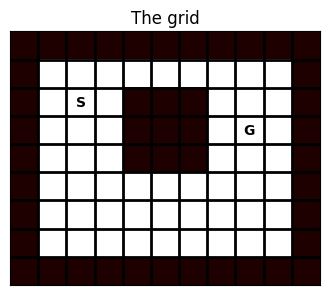

In [ ]:
grid = Grid()
grid.plot_grid()

### Helper functions

In [ ]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    log_every = 100
    mean_reward_log = np.zeros(number_of_steps//log_every-1)
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = grid.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)
      if i>0 and i % log_every == 0:
        mean_reward_log[i//log_every-1] = mean_reward
    return mean_reward, mean_reward_log


def plot_values(values, colormap='pink', vmin=0, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])


# Part 1: Implement agents

Each agent, should implement a step function:

### `step(self, reward, discount, next_observation, ...)`:
where `...` indicates there could be other inputs (discussed below).  The step should update the internal values, and return a new action to take.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" (for whatever definition of $v$ is appropriate) in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function.

### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get the initial observation by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`.

In this assignment, observations will be states in the environment, so the agent state, environment state, and observation will overlap, and we will use the word `state` interchangably with `observation`.

All agents should be in pure Python (no need to use TensorFlow or PyTorch).  Using `numpy` is fine.

### A note on the initial action
Normally, you would also have to implement a method that gives the initial action, based on the initial state.  In our experiments the helper functions above will just use the action `0` (which corresponds to `up`) as initial action, so that otherwise we do not have to worry about this.  Note that this initial action is only executed once, and the beginning of the first episode---not at the beginning of each episode.

Some algorithms (Q-learning, Sarsa) need to remember the last action in order to update its value when they see the next state.  In the `__init__`, make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._last_action = 0
  (...)
```


### The grid

The cell below shows the `Grid` environment that we will use. Here `S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.  Feel free to reference the implemetation of the `Grid` above, under the header "a grid world".

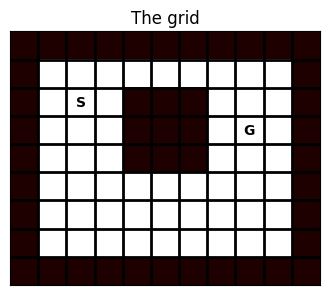

In [ ]:
grid = Grid()
grid.plot_grid()
num_actions = 4

## Random agent

In [ ]:
# For reference: here is a random agent
class Random(object):

  def __init__(self, number_of_actions, number_of_states, initial_state):
    self._number_of_actions = number_of_actions

  def step(self, reward, discount, next_state):
    next_action = np.random.randint(number_of_actions)
    return next_action


## Agent 1: TD learning
**[5 pts]** Implement an agent that behaves randomly, but that _on-policy_ estimates state values $v(s)$, using one-step TD learning with a step size $\alpha=0.1$.

Also implement `get_values(self)` that returns the vector of all state values (one value per state).

You should be able to use the `__init__` as provided below, so you just have to implement `get_values` and `step`.  We store the initial state in the constructor because you need its value on the first `step` in order to compute the TD error when the first transition has occurred.  Hint: in the `step` you similarly will want to store the previous state to be able to compute the next TD error on the next step.


In [ ]:
class RandomTD(object):

  def __init__(self, number_of_states, number_of_actions, initial_state, step_size=0.1):
    self._values = np.zeros(number_of_states)
    self._state = initial_state
    self._number_of_actions = number_of_actions
    self._step_size = step_size

  def get_values(self):
    return self._values

  def step(self, reward, discount, next_state):
    target = reward + discount * self._values[next_state]
    delta  = target - self._values[self._state]
    self._values[self._state] += self._step_size * delta
    self._state = next_state
    return np.random.randint(0, self._number_of_actions)

Run the next cell to run the `RandomTD` agent on a grid world.

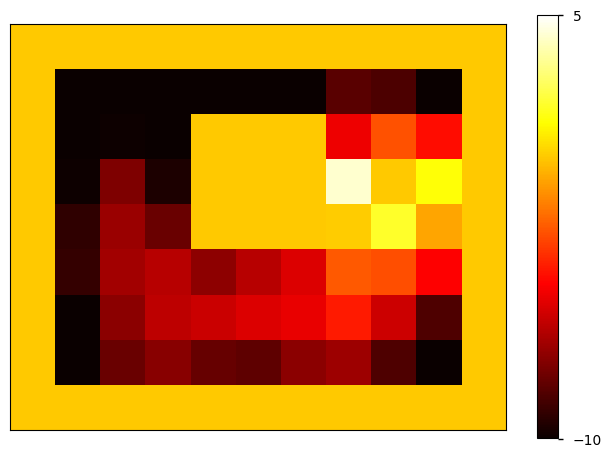

In [ ]:
# DO NOT MODIFY THIS CELL
grid = Grid()
init_state = grid.get_obs()
agent = RandomTD(grid._layout.size, num_actions, init_state)
run_experiment(grid, agent, int(1e5))
v = agent.get_values()
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)

If everything worked as expected, the plot above will show the estimates state values under the random policy. This includes values for unreachable states --- on the walls and on the goal (we never actually reach the goal --- rather, the episode terminates on the transition to the goal.  The values on the walls and goal are, and will always remain, zero (shown in orange above).

### Policy iteration
We used TD to do policy evaluation for the random policy on this problem.  Consider doing policy improvement, by taking the greedy policy with respect to a one-step look-ahead.  For this, you may assume we have a true model - so for each state the policy would look at the value of the resulting state for each action, and would then pick the action with the highest state value. You do **not** have to implement this, just answer the following questions.

**[5 pts]** Would the greedy step after one such iteration of policy evaluation and policy improvement be optimal on this problem?  Explain (in one or two sentences) why or why not.

<font color='red'>Answer:
Assuming agent picks randomly when having a number of maximas, one-step lookahead wouldn't give optimal policy. When we sample the trajectory, we will move randomly, so we might hit the wall and learn nothing about the shortest path to the goal. this means that even after the TD update (which will simply be the reward at each state multiplied by $γ$), we still have a non-zero probability to not take the optimal path, which will at best case increase the exponent of the discount factor, and in the worst case end up with us hitting another wall./font>

**[5 pts]** If we repeat the process over and over again, and repeatedly evaluate the greedy policy and then perform another improvement step, would then the policy eventually become optimal?  Explain (in one or two sentences) why or why not.

<font color='red'>Answer:
by the convergence of TD learning we know that we can find the true value function $v_π$. and as we proved in class, greedification can only improve the value function. this means that we keep improving until convergence, and we proved convergence only happens at the global maxima, thus we can say that this algorithm converges towards the optimal policy</font>


## Agent 2: SARSA
**[5 pts]** Implement an $\epsilon$-greedy policy function.

**[10 pts]** Implement a **Sarsa** agent. Now the `__init__` function receives a policy function as input, and you need to maintain a value function for (state, action) pairs, denoted by  **Q**.


In [ ]:
class EpsilonGreedy(object):

  def __init__(self, epsilon):
    self._epsilon = epsilon

  def get_action(self, Qvalues, state):
    roll = np.random.rand()
    if(roll < self._epsilon):
      action = np.random.randint(0, Qvalues.shape[1])
    else:
      action =  np.argmax(Qvalues[state])
    return action


In [ ]:
class Sarsa(object):

  def __init__(self, number_of_states, number_of_actions,
               policy, initial_state, step_size=0.1):
    self._Qvalues = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_actions = number_of_actions
    self._policy = policy
    self._step_size = step_size

  def get_values(self):
    return self._Qvalues

  def step(self, reward, discount, next_state):
    next_action = self._policy.get_action(self._Qvalues, next_state)
    target = reward + discount * self._Qvalues[next_state, next_action]
    delta = target - self._Qvalues[self._state, self._action]

    self._Qvalues[self._state, self._action] += self._step_size * delta

    self._action = next_action
    self._state = next_state
    return next_action

Run the next cell. This will train your Sarsa agent using an $\epsilon$-greedy policy with $\epsilon=0.1$.

After training a state value is computed using a one-step greedy evaluation:
$V(s) = \max_a Q(s, a)$

The figure on the left shows the value for each state in the grid, and the plot on the right shows the average reward received along the training episodes(always averaged from the first step).

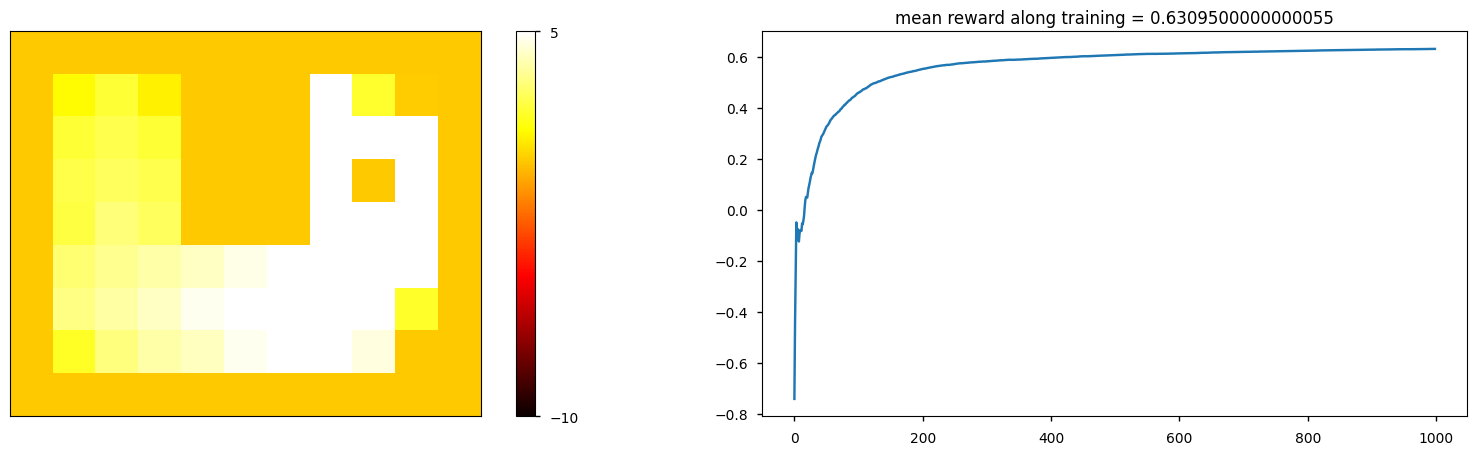

In [ ]:
# DO NOT MODIFY THIS CELL
# set-up epsilon greedy policy function with epsilon=0.1
policy = EpsilonGreedy(epsilon=0.1)

# start environment and get initial state
grid = Grid()
init_state = grid.get_obs()

# start agent
agent = Sarsa(grid._layout.size, num_actions, policy, init_state)

# run expriments and get Q-values.
mean_reward, mean_reward_log = run_experiment(grid, agent, int(1e5))
q_values = agent.get_values()

# compute the one-step greedy state values
v = np.max(q_values, axis=1)

# show results
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)
plt.subplot(1, 2, 2)
plt.plot(mean_reward_log)
t=plt.title('mean reward along training = {}'.format(mean_reward))



## Agent 3: Sarsa($\lambda$)
**[10 pts]** Implement a **Sarsa($\lambda$)** agent.
Now you need to maintain a table of eligibility traces, and update the Q-value of all (state, action) pairs in each step.


In [ ]:
class SarsaLambda(object):

  def __init__(self, number_of_states, number_of_actions,
               lmbda, policy, initial_state, step_size=0.1):
    self._Qvalues = np.zeros((number_of_states, number_of_actions))
    self._Etraces = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_actions = number_of_actions
    self._lmbda = lmbda
    self._policy = policy
    self._step_size = step_size

  def get_values(self):
    return self._Qvalues

  def step(self, reward, discount, next_state):
    next_action = self._policy.get_action(self._Qvalues, next_state)

    target = reward + discount * self._Qvalues[next_state, next_action]
    delta = target - self._Qvalues[self._state, self._action]
    self._Etraces[self._state, self._action] +=1

    self._Qvalues += self._step_size * delta * self._Etraces
    self._Etraces = discount * self._lmbda *  self._Etraces

    self._action = next_action
    self._state = next_state
    return next_action

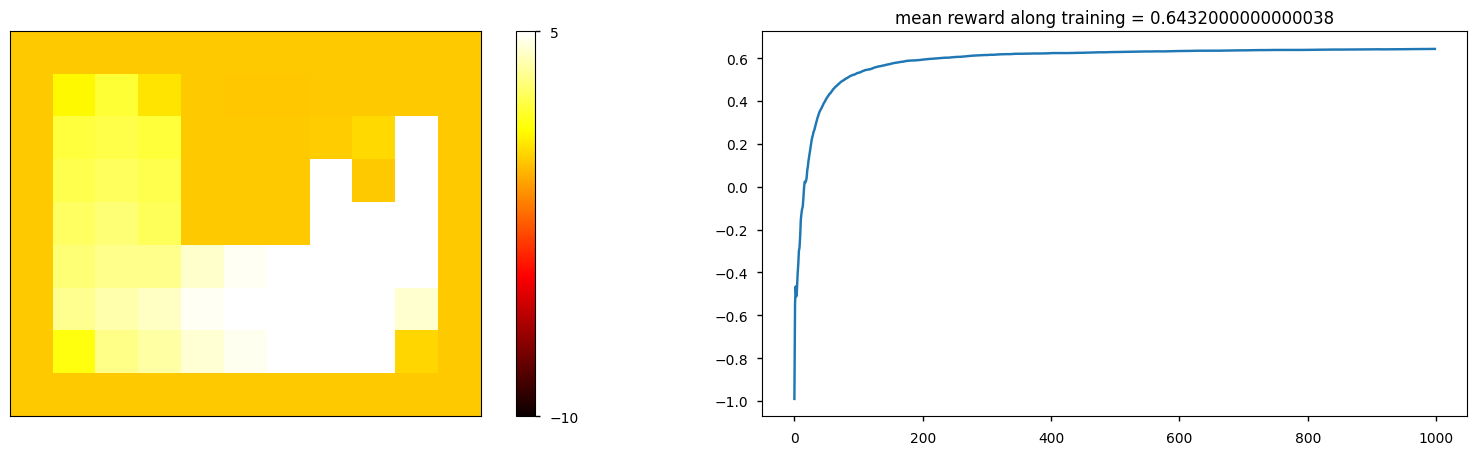

In [ ]:
# DO NOT MODIFY THIS CELL
# set-up epsilon greedy policy function with epsilon=0.1
policy = EpsilonGreedy(epsilon=0.1)

lmbda = 0.1

# start environment and get initial state
grid = Grid()
init_state = grid.get_obs()

# start agent
agent = SarsaLambda(
    grid._layout.size, num_actions, lmbda, policy, grid.get_obs())

# run expriments and get Q-values.
mean_reward, mean_reward_log = run_experiment(grid, agent, int(1e5))
q_values = agent.get_values()

# compute the one-step greedy state values
v = np.max(q_values, axis=1)

# show results
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)
plt.subplot(1, 2, 2)
plt.plot(mean_reward_log)
t=plt.title('mean reward along training = {}'.format(mean_reward))


## Agent 4: Q-learning
**[10 pts]** Implement a **Q-learning** agent. The agent recevies a behavior policy at __init__, but always learns the Q values for the greedy policy.


In [ ]:
class QLearning(object):

  def __init__(self, number_of_states, number_of_actions,
               policy, initial_state, step_size=0.1):
    self._Qvalues = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_actions = number_of_actions
    self._policy = policy
    self._step_size = step_size

  def get_values(self):
    return self._Qvalues

  def step(self, reward, discount, next_state):
    next_action = self._policy.get_action(self._Qvalues, next_state)
    target = reward + discount * np.max(self._Qvalues[next_state])
    delta = target - self._Qvalues[self._state, self._action]

    self._Qvalues[self._state, self._action] += self._step_size * delta

    self._action = next_action
    self._state = next_state
    return next_action

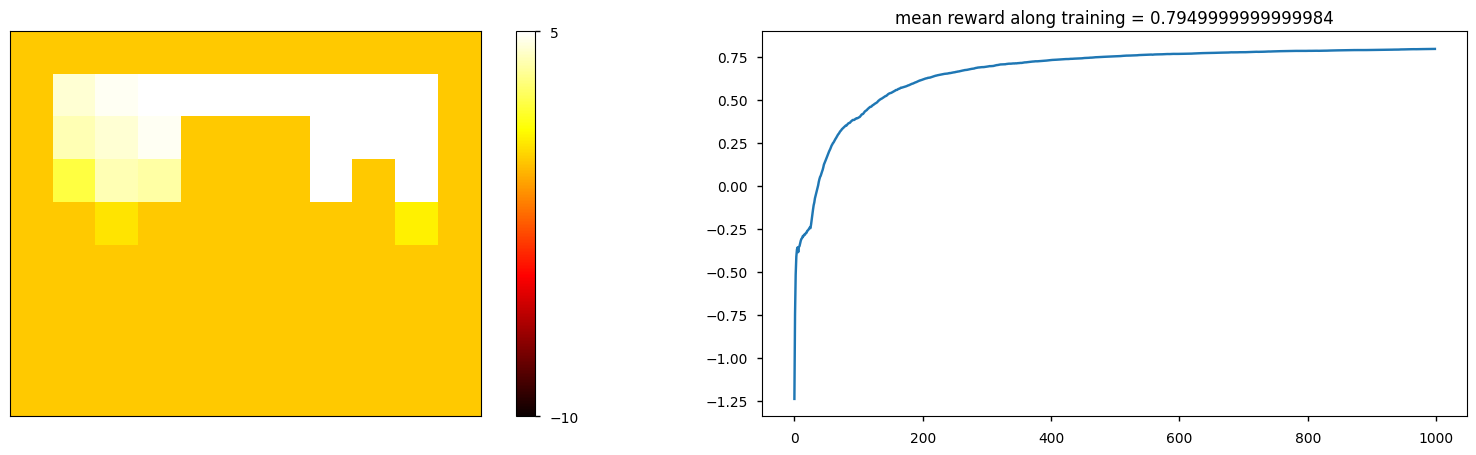

In [ ]:
# DO NOT MODIFY THIS CELL
# set-up epsilon greedy policy function with epsilon=0.1
policy = EpsilonGreedy(epsilon=0.1)

# start environment and get initial state
grid = Grid()
init_state = grid.get_obs()

# start agent
agent = QLearning(grid._layout.size, num_actions, policy, grid.get_obs())

# run expriments and get Q-values.
mean_reward, mean_reward_log = run_experiment(grid, agent, int(1e5))
q_values = agent.get_values()

# compute the one-step greedy state values
v = np.max(q_values, axis=1)

# show results
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)
plt.subplot(1, 2, 2)
plt.plot(mean_reward_log)
t=plt.title('mean reward along training = {}'.format(mean_reward))


## Agent 5: General Q-learning
**[15 pts]** Here you will consider a generalization of Q-learning and Sarsa.

Remember from class, that Q learning can be implemented using any two policies:
1. Behavior policy - used to act in the environment
2. Target policy - used as a target for the value updates.

Impement a **General Q-learning** agent, where the `__init__` takes as input a `target_policy` and a  `behavior_policy`.  The agent will act according to the behavior policy, and learn the Q-values of the target policy.
The TD target becomes:
$$r + \gamma \sum_a \mathcal{P}_s^{\texttt{target}}(a) Q(s, a))$$
where $s$ is the new state sent as input to the agent's `step` function.

The standard Q-learning is a special case where the target policy is the greedy policy, and Sarsa is the special case where the target policy is the same as the behavior policy.

**[5 pts]** To implement this, you will first need to add a function to the `EpsilonGreedy` class that returns the probabilities of all actions for a given state.

In [ ]:
class EpsilonGreedy(object):

  def __init__(self, epsilon):
    self._epsilon = epsilon

  def get_action_probs(self, Qvalues, state):
    max_action = np.argmax(Qvalues[state])
    action_probs = np.eye(Qvalues.shape[1])[max_action]
    action_probs[max_action] -= self._epsilon
    action_probs += self._epsilon / len(action_probs)

    return action_probs

  def get_action(self, Qvalues, state):
    roll = np.random.rand()
    if(roll < self._epsilon):
      action = np.random.randint(0, Qvalues.shape[1])
    else:
      action =  np.argmax(Qvalues[state])
    return action

In [ ]:
class GeneralQLearning(object):

  def __init__(self, number_of_states, number_of_actions,
               behavior_policy, target_policy, initial_state, step_size=0.1):
    self._Qvalues = np.zeros((number_of_states, number_of_actions))
    self._state = initial_state
    self._action = 0
    self._number_of_actions = number_of_actions
    self._behavior_policy = behavior_policy
    self._target_policy = target_policy
    self._step_size = step_size

  def get_values(self):
    return self._Qvalues

  def step(self, reward, discount, next_state):
    next_action = self._behavior_policy.get_action(self._Qvalues, next_state)
    target = reward + discount * self._target_policy.get_action_probs(self._Qvalues, next_state) @ self._Qvalues[next_state]
    delta = target - self._Qvalues[self._state, self._action]

    self._Qvalues[self._state, self._action] += self._step_size * delta

    self._action = next_action
    self._state = next_state
    return next_action


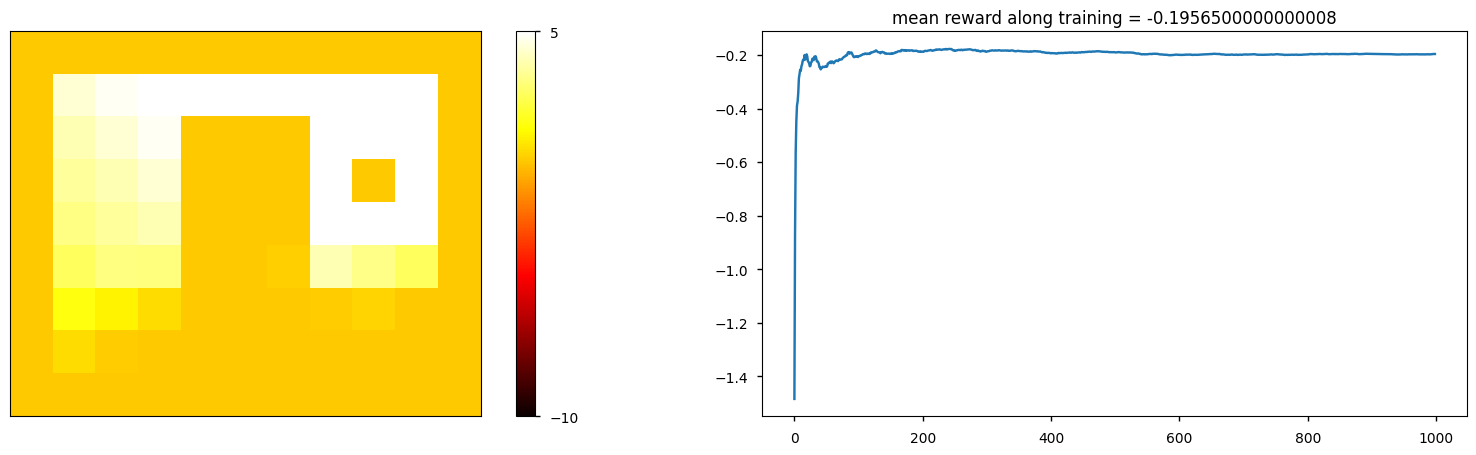

In [ ]:
# DO NOT MODIFY THIS CELL
# set-up behavior and target policies
b_policy = EpsilonGreedy(0.5)
t_policy = EpsilonGreedy(0.)

# start environment and get initial state
grid = Grid()
init_state = grid.get_obs()

# start agent
agent = GeneralQLearning(grid._layout.size, num_actions,
                         b_policy, t_policy, grid.get_obs())

# run expriments and get Q-values.
mean_reward, mean_reward_log = run_experiment(grid, agent, int(1e5))
q_values = agent.get_values()

# compute the one-step greedy state values
v = np.max(q_values, axis=1)

# show results
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)
plt.subplot(1, 2, 2)
plt.plot(mean_reward_log)
t=plt.title('mean reward along training = {}'.format(mean_reward))


# Part 2: Analyse Results

## Questions

**[10 pts]** *How* do the policies found by Q-learning and Sarsa differ?  (Explain qualitatively how the behaviour differs in one or two sentences.)

<font color='red'>Answer: Q-learning is much better in terms of both path length found, and the mean reward along the training (as it finds a shorter path which ensures more episodes over the same number of steps and less discount factor effect, and thus more accumulative reward). However,Q learning is slower in convergence: it converged after ~180 steps, while SARSA took only about 50 steps to stabilize. Notice that the value function of the greedy policy we learn in Q-learning is always higher than the epsilon greedy one we learn in SARSA as exploration might reduce the overall reward due to non-optimal behavior</font><br/>

**[10 pts]** *Why* do the policies differ in this way?

<font color='red'>Answer: There are several related factors:<br/>
- The combination of two different policies - the agent travels using an epsilon greedy policy which ensures exploration from one side, but saved the best deterministic policy. In this example, it is a good idea to maintain two different policies, instead of the same policy for behaving and learning (as SARSA does).
- When updating towards deterministic greedy target policy, the TD target does towards the higest action value, instead of going in the action value picked by random action. This also speeds up the convergence.</font><br/>

**[5 pts]** Run the Sarsa($\lambda$) agent for different values of $\lambda$ (e.g. 0.1 and 0.9), and report the results.

**[5 pts]** Run the general Q-learning agent with different behavior policies and target policies, and report the results.

For the last two questions you can generate plots, reports statistics of rewards and/or values. You can also state any qualitative observation that you make.

Question 3:

100%|██████████| 5/5 [00:09<00:00,  1.91s/it]


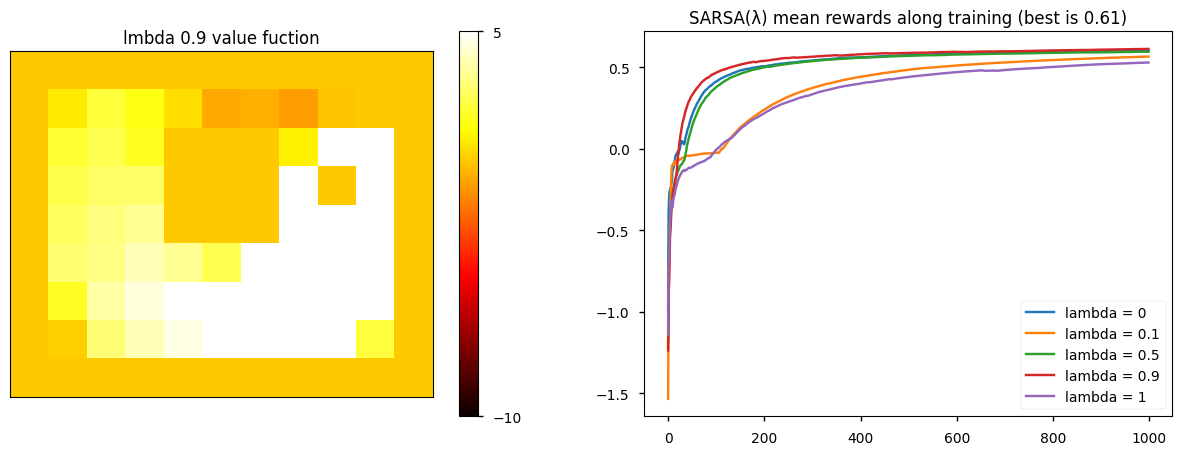

In [ ]:
from tqdm import tqdm

policy = EpsilonGreedy(epsilon=0.1)

lmbdas = [0, 0.1, 0.5, 0.9, 1]

# start environment and get initial state

mean_log = []
max_mean = -1
best_lmbda = -1

for lmbda in tqdm(lmbdas):
  grid = Grid()
  agent = SarsaLambda(
    grid._layout.size, num_actions, lmbda, policy, grid.get_obs())

  # run expriments and get Q-values.
  mean_reward, mean_reward_log = run_experiment(grid, agent, int(1e5))
  mean_log.append(mean_reward_log)
  if mean_reward > max_mean:
    q_values = agent.get_values()
    max_mean = mean_reward
    best_lmbda = lmbda

# compute the one-step greedy state values
v = np.max(q_values, axis=1)

# show results
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title(f"lmbda {best_lmbda} value fuction")
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)

plt.subplot(1, 2, 2)

for idx, lmbda in enumerate(lmbdas):
  plt.plot(mean_log[idx], label=f"lambda = {lmbda}")
plt.legend()
t=plt.title(f'SARSA(λ) mean rewards along training (best is {max_mean:.2f})')

Question 4 <br/>
We try the following options:
- learn greedy policy from random policy
- learn epsilon greedy policy from random policy


- learn epsilon greedy policy from epsilon greedy policy
- learn greedy policy from epsilon greedy policy


- learn epsilon greedy policy from greedy policy
- learn greedy policy from greedy policy


At each of them, we use the same epsilon of 0.1

We can see from the first two results that learning (almost) greedy policies from random policy is not that bad; in terms of the exploration vs exploitation tradeoff - we learn (almost) deterministic policies but keep exploring.<br/>

However, in the middle two results, when learning (almost) greedy policies from (small) epsilon greedy policies we mostly go in the direction of highest values (exploitation) and leave a small space for exploration as well. This ends in faster convergence and shorter path to the goal.<br/>

The last to results are interesting - when both learning and behaving greedy, of course we will learn nothing, because we started with zero value function and no exploration at all. However, when we learn an epsilon greedy policy we take the best action but update towards (small) random direction. This finds the fastest path since it takes the best and looks just little bit around.

In fact, We expect that using even smaller epsilon will do better, as shown in the next cell.

100%|██████████| 6/6 [00:13<00:00,  2.28s/it]


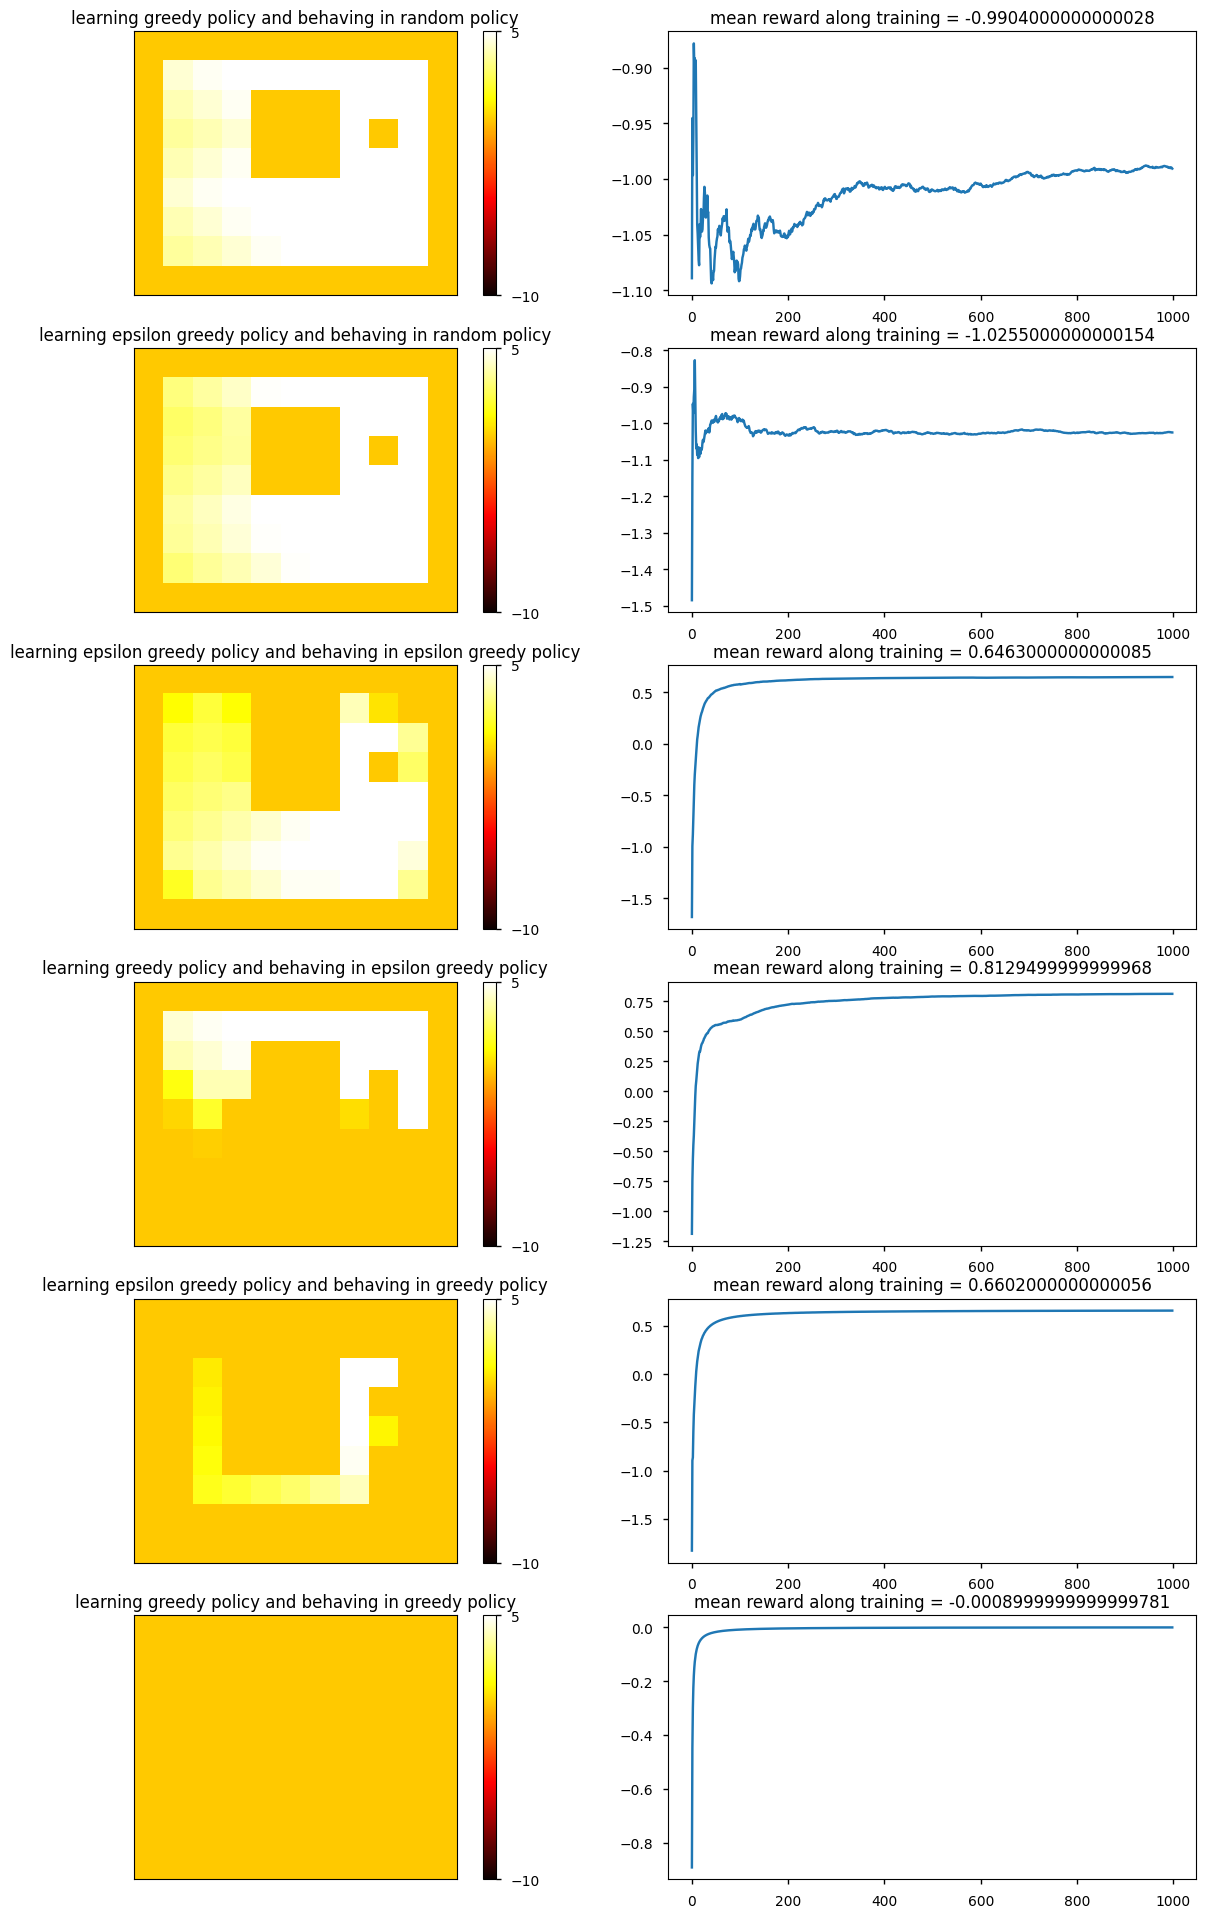

In [ ]:
from tqdm import tqdm

exprs = [[1, 0],
         [1, 0.1],
         [0.1, 0.1],
         [0.1, 0],
         [0, 0.1],
         [0, 0]]
mapping = {1: "random", 0.1: "epsilon greedy", 0: "greedy"}

data_log = []
for b, t in tqdm(exprs):

  b_policy = EpsilonGreedy(b)
  t_policy = EpsilonGreedy(t)

  grid = Grid()
  agent = GeneralQLearning(grid._layout.size, num_actions,
                         b_policy, t_policy, grid.get_obs())

  # run expriments and get Q-values.
  mean_reward, mean_reward_log = run_experiment(grid, agent, int(1e5))

  q_values = agent.get_values()
  v = np.max(q_values, axis=1)

  data_log.append([mean_reward, mean_reward_log, v])

plt.figure(figsize=(15,24))
for idx, (b,t) in enumerate(exprs):
  plt.subplot(6, 2, idx * 2 + 1)
  plt.title(f"learning {mapping[t]} policy and behaving in {mapping[b]} policy")
  plot_values(data_log[idx][2].reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)

  plt.subplot(6, 2, idx * 2 + 2)
  plt.plot(data_log[idx][1])
  plt.title(f"mean reward along training = {data_log[idx][0]}")

plt.show()

As we claimed, smaller epsilon got us even smoother result (compare the outputs)

100%|██████████| 3/3 [00:08<00:00,  2.95s/it]


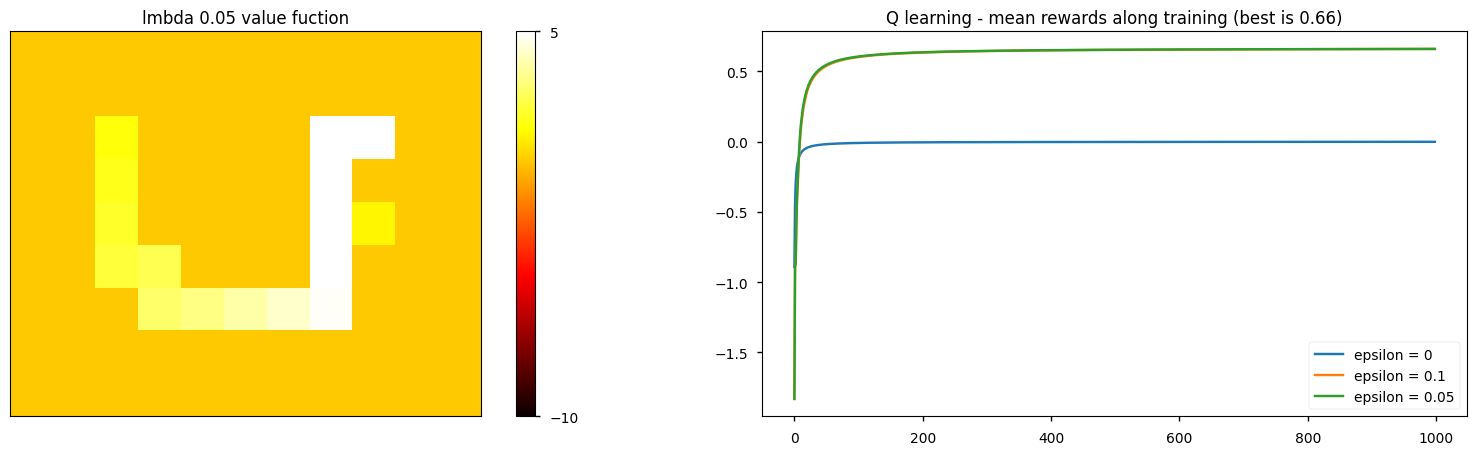

In [ ]:
from tqdm import tqdm

epsilons = [0, 0.1, 0.05]

# start environment and get initial state

mean_log = []
max_mean = -1
best_eps = -1

for epsilon in tqdm(epsilons):
  b_policy = EpsilonGreedy(0)
  t_policy = EpsilonGreedy(epsilon)

  grid = Grid()
  agent = GeneralQLearning(grid._layout.size, num_actions,
                         b_policy, t_policy, grid.get_obs())

  # run expriments and get Q-values.
  mean_reward, mean_reward_log = run_experiment(grid, agent, int(1e5))
  mean_log.append(mean_reward_log)
  if mean_reward > max_mean:
    q_values = agent.get_values()
    max_mean = mean_reward
    best_eps = epsilon

# compute the one-step greedy state values
v = np.max(q_values, axis=1)

# show results
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.title(f"lmbda {best_eps} value fuction")
plot_values(v.reshape(grid._layout.shape), colormap="hot", vmin=-10, vmax=5)

plt.subplot(1, 2, 2)

for idx, epsilon in enumerate(epsilons):
  plt.plot(mean_log[idx], label=f"epsilon = {epsilon}")
plt.legend()
t=plt.title(f'Q learning - mean rewards along training (best is {max_mean:.2f})')